# Packages

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Functions and constants

In [ ]:
# run wind_all_days.py and wind_extreme_days.py by submitting jobs in GADI on the the terminal to get wind_all_days.nc and wind_extreme_days.nc

# Read data

In [5]:
# Load the datasets for extreme days and all days
file_extreme = 'wind_time_avg_levels_extreme_days.nc'
file_all_days = 'wind_time_avg_levels_all_days.nc'

ds_extreme = xr.open_dataset(file_extreme)
ds_all_days = xr.open_dataset(file_all_days)

# Extract wind speed, wind direction, latitude, longitude, and levels
wind_speed_extreme = ds_extreme['wind_speed']
wind_direction_extreme = ds_extreme['wind_direction']

wind_speed_all_days = ds_all_days['wind_speed']
wind_direction_all_days = ds_all_days['wind_direction']

latitude = ds_extreme['latitude']
longitude = ds_extreme['longitude']
levels = ds_extreme['level']

# Analysis

In [6]:
# Calculate wind speed anomaly: extreme days - all days
wind_speed_anomaly = wind_speed_extreme - wind_speed_all_days

# Calculate wind direction anomaly (extreme days - all days) by subtracting direction angles
# Wrap the result to stay within the range of 0 to 360 degrees
wind_direction_anomaly = (wind_direction_extreme - wind_direction_all_days) % 360

# Plots

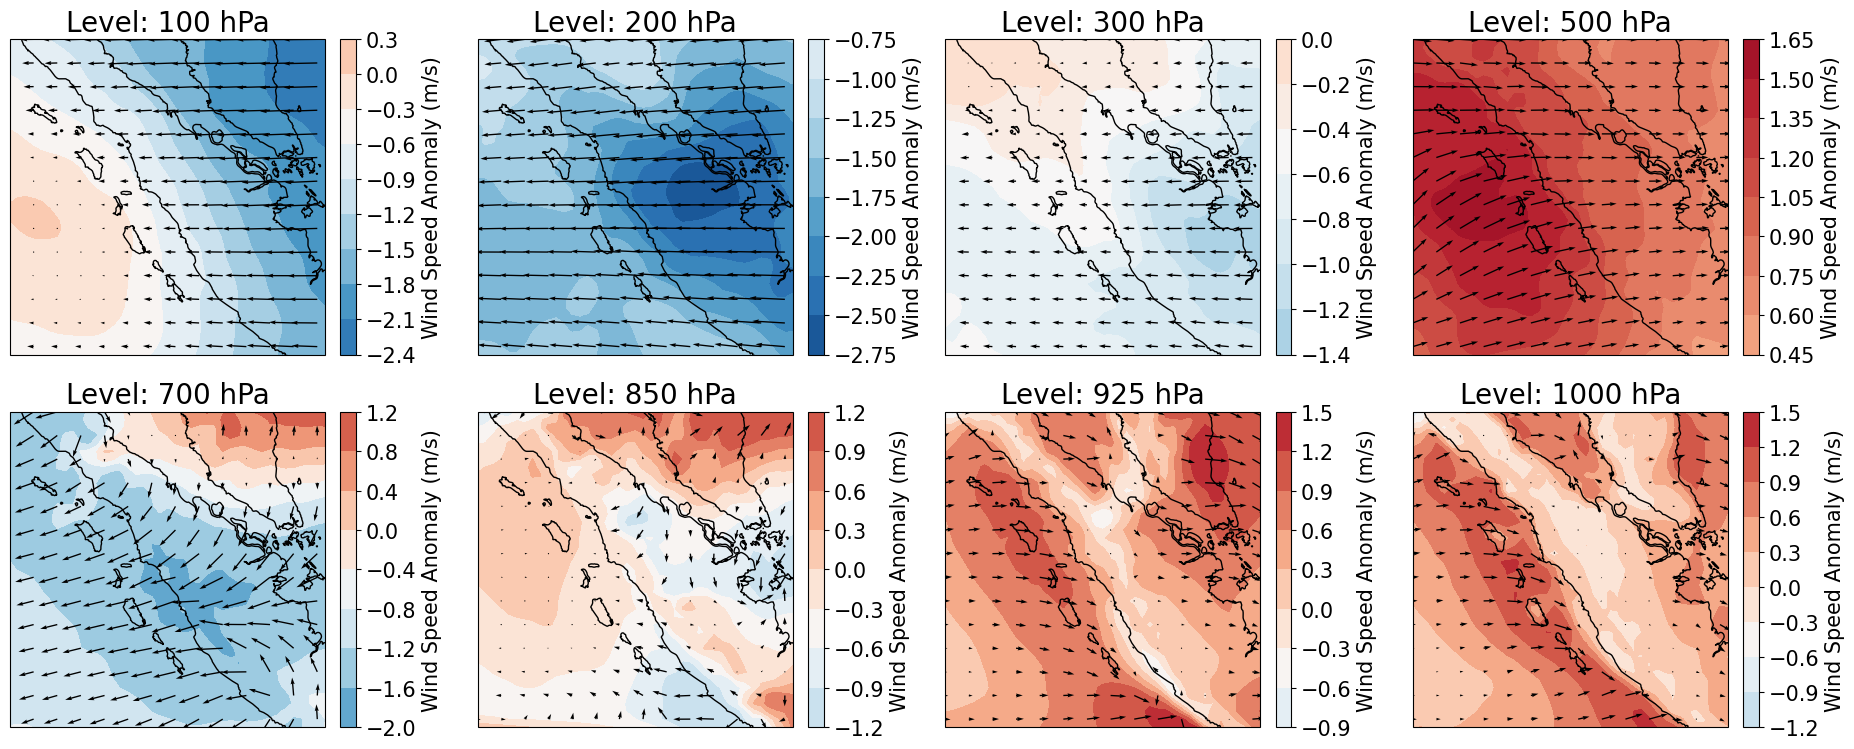

In [8]:
# Find the global min and max for wind speed anomalies for consistent scaling
vmin = wind_speed_anomaly.min().item()
vmax = wind_speed_anomaly.max().item()

# Set up the figure with 4 columns and 2 rows
ncols = 4
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the axes array to iterate easily over it
ax = ax.flatten()

# Add a title for the entire figure and center it
#fig.suptitle('Anomalies of Wind Speed and Direction at Different Levels of Extreme Events', 
#             fontsize=20, ha='center', x=0.44, y=0.95)  # Adjust y for vertical position

# Loop through each level to create the plots (up to 8 levels in a 4x2 grid)
for i, level in enumerate(levels[:ncols * nrows]):  # Ensure we only plot up to 8 levels
    ax[i].set_title(f'Level: {level.data} hPa', fontsize=20)

    # Add coastlines and features
    ax[i].coastlines()
    ax[i].add_feature(cfeature.BORDERS, linestyle=':')

    # Set the same extent for all plots (consistent domain size)
    ax[i].set_extent([longitude.min().item(), longitude.max().item(), latitude.min().item(), latitude.max().item()], crs=ccrs.PlateCarree())

    # Contour plot of wind speed anomaly with fixed vmin=-3 and vmax=2 for consistent scaling across all levels
    cs = ax[i].contourf(longitude, latitude, wind_speed_anomaly.sel(level=level), cmap='RdBu_r', 
                        transform=ccrs.PlateCarree(), vmin=-3, vmax=2)

    # Reduce the number of grid points for arrows by slicing
    stride = 3  # Adjust the stride for arrow density (higher = fewer arrows)
    lon_slice = longitude[::stride]
    lat_slice = latitude[::stride]
    
    # Calculate the u, v components for the anomaly quiver plot
    u_anomaly = wind_speed_anomaly.sel(level=level)[::stride, ::stride] * np.cos(np.deg2rad(wind_direction_anomaly.sel(level=level)[::stride, ::stride]))
    v_anomaly = wind_speed_anomaly.sel(level=level)[::stride, ::stride] * np.sin(np.deg2rad(wind_direction_anomaly.sel(level=level)[::stride, ::stride]))

    # Overlay wind direction arrows for anomalies with consistent scale
    ax[i].quiver(lon_slice, lat_slice, u_anomaly, v_anomaly, scale=20, color='black', transform=ccrs.PlateCarree())
    
    # Add individual color bar for each plot, adjust colorbar height to match plot height
    cbar = fig.colorbar(cs, ax=ax[i], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Wind Speed Anomaly (m/s)', fontsize=15)  # Set the label for the color bar
    cbar.ax.tick_params(labelsize=15)
            
# Hide any unused subplots if there are fewer levels than 8
for j in range(i+1, ncols * nrows):
    fig.delaxes(ax[j])

plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust the layout to make space for the title
plt.show()

# Close the datasets to free up resources
ds_extreme.close()
ds_all_days.close()

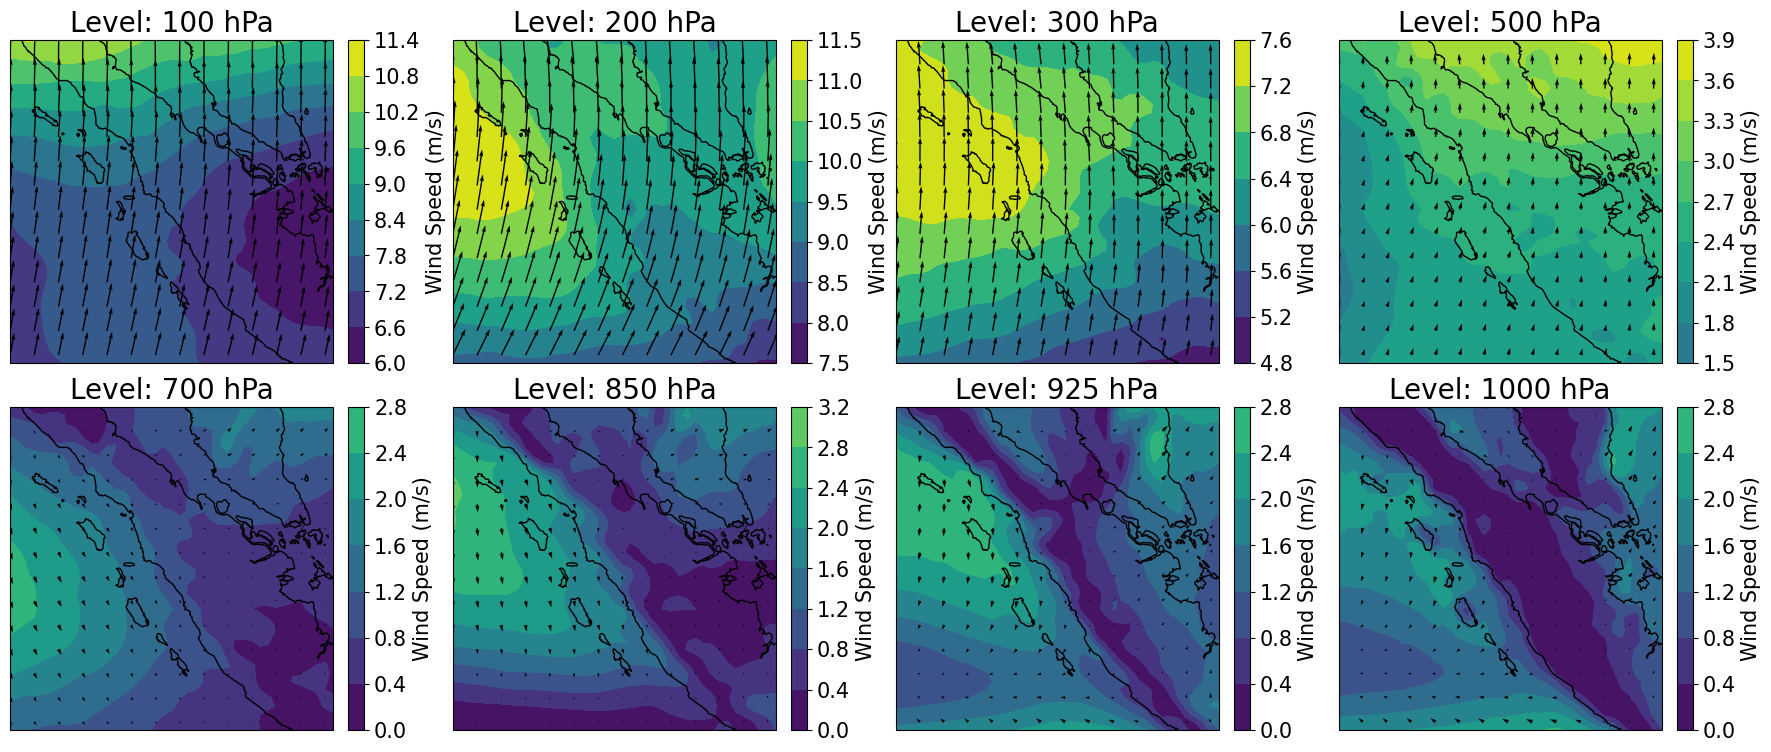

In [12]:
# Extract wind speed, wind direction, latitude, longitude, and levels
wind_speed = ds_extreme['wind_speed']
wind_direction = ds_extreme['wind_direction']
latitude = ds_extreme['latitude']
longitude = ds_extreme['longitude']
levels = ds_extreme['level']

# Define latitude and longitude limits for all plots
lat_min, lat_max = latitude.min().item(), latitude.max().item()  # Adjust based on your dataset
lon_min, lon_max = longitude.min().item(), longitude.max().item()  # Adjust based on your dataset

# Set up the figure with 4 columns and 2 rows
ncols = 4
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the axes array to iterate easily over it
ax = ax.flatten()

# Add a title for the entire figure and center it
#fig.suptitle('Time Average of Wind Speed and Direction at Different Levels of Extreme Days', 
#            fontsize=20, ha='center', x=0.44, y=0.95)  # Adjust y for vertical position

# Loop through each level to create the plots (up to 8 levels in a 4x2 grid)
for i, level in enumerate(levels[:ncols * nrows]):  # Ensure we only plot up to 8 levels
    ax[i].set_title(f'Level: {level.data} hPa', fontsize=20)

    # Add coastlines and features
    ax[i].coastlines()
    ax[i].add_feature(cfeature.BORDERS, linestyle=':')

    # Set the same extent for all plots (consistent domain size)
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Force the colorbar scale for levels 500, 700, 850, 925, and 1000 hPa
    if level.data in [500, 700, 850, 925, 1000]:
        vmin_value = 0  # Set minimum value for colorbar
        vmax_value = 4.0  # Set maximum value for colorbar
    else:
        vmin_value = None  # Use default scaling for other levels
        vmax_value = None  # Use default scaling for other levels

    # Contour plot of wind speed with forced colorbar scale
    cs = ax[i].contourf(longitude, latitude, wind_speed.sel(level=level), 
                        cmap='viridis', transform=ccrs.PlateCarree(), vmin=vmin_value, vmax=vmax_value)

    # Reduce the number of grid points for arrows by slicing
    stride = 3  # Adjust the stride for arrow density (higher = fewer arrows)
    lon_slice = longitude[::stride]
    lat_slice = latitude[::stride]

    # Overlay wind direction arrows (convert direction to u, v components)
    u = wind_speed.sel(level=level)[::stride, ::stride] * np.cos(np.deg2rad(wind_direction.sel(level=level)[::stride, ::stride]))
    v = wind_speed.sel(level=level)[::stride, ::stride] * np.sin(np.deg2rad(wind_direction.sel(level=level)[::stride, ::stride]))

    # Use quiver for arrows instead of barbs
    ax[i].quiver(lon_slice, lat_slice, u, v, scale=100, color='black', transform=ccrs.PlateCarree())

    # Add individual color bar for each plot, adjust colorbar height to match plot height
    cbar = fig.colorbar(cs, ax=ax[i], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Wind Speed (m/s)', fontsize=15)  # Set the label for the color bar
    cbar.ax.tick_params(labelsize=15)

# Hide any unused subplots if there are fewer levels than 8
for j in range(i+1, ncols * nrows):
    fig.delaxes(ax[j])

plt.tight_layout(rect=[0, 0, 0.9, 0.95], pad=1.0, h_pad=0.1)  # Adjust h_pad to reduce vertical spacing
plt.show()

# Close the dataset to free up resources
ds_extreme.close()